---
title: GMST from AWS CMIP6 data
author: Harsha R. Hampapura
data: 2026-02-03
---

## Access CMIP6 zarr data from AWS using the osdf protocol and compute GMSTA on a Jetstream2 Exosphere instance
- This workflow is inspired by https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html 
## Table of Contents
- [Section 1: Introduction](#Section-1:-Introduction) 
- [Section 2: Select Dask Cluster](#Section-2:-Select-Dask-Cluster) 
- [Section 3: Data Loading](#Section-3:-Data-Loading) 
- [Section 4: Data Analysis](#Section-4:-Data-Analysis) 

## Section 1: Introduction
- Load python packkages
- Load catalog url

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
import aiohttp
import dask
from dask.distributed import LocalCluster
import pelicanfs 
import os
from pelicanfs.core import OSDFFileSystem,PelicanMap 

/tmp/ipykernel_3608/4282021079.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
#
gdex_url    =  'https://data.gdex.ucar.edu/'
cat_url     = gdex_url +  'd850001/catalogs/osdf/cmip6-aws/cmip6-osdf-zarr.json'

## Section 2: Select Dask Cluster
- Setting up a dask cluster. 
- The default will be LocalCluster as that can run on any system.

In [4]:
cluster = LocalCluster()
client = cluster.get_client()

In [5]:
# Scale the local cluster
n_workers = 5
cluster.scale(n_workers)
cluster

LocalCluster(e2f4426c, 'tcp://127.0.0.1:37245', workers=4, threads=8, memory=29.37 GiB)

## Section 3: Data Loading
- Load catalog and select data subset

In [6]:
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,61


In [7]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126Lu',
 'ssp585',
 'ssp245',
 'ssp370-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370SST',
 'ssp370pdSST',
 'ssp370SST-lowCH4',
 'ssp370SST-lowNTCF',
 'ssp126',
 'ssp119',
 'ssp370',
 'esm-ssp585',
 'ssp245-nat',
 'ssp245-GHG',
 'ssp460',
 'ssp434',
 'ssp534-over',
 'ssp245-aer',
 'ssp245-stratO3',
 'ssp245-cov-fossil',
 'ssp245-cov-modgreen',
 'ssp245-cov-strgreen',
 'ssp245-covid',
 'ssp585-bgc']

In [8]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp245', 'ssp370']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    member_id = 'r1i1p1f1',
    #activity_id = 'CMIP',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset

,unique
activity_id,2
institution_id,20
source_id,27
experiment_id,3
member_id,1
table_id,1
variable_id,1
grid_label,3
zstore,81
dcpp_init_year,1


In [9]:
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id","activity_id"]].nunique()

,experiment_id,variable_id,table_id,activity_id
source_id,,,,
ACCESS-CM2,3,1,1,2
AWI-CM-1-1-MR,3,1,1,2
BCC-CSM2-MR,3,1,1,2
CAMS-CSM1-0,3,1,1,2
CAS-ESM2-0,3,1,1,2
CESM2-WACCM,3,1,1,2
CMCC-CM2-SR5,3,1,1,2
CMCC-ESM2,3,1,1,2
CanESM5,3,1,1,2


In [10]:
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,<NA>,20191108
1,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp245,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,<NA>,20191108
2,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,<NA>,20191108
3,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp245,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,<NA>,20190529
4,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,<NA>,20190529
...,...,...,...,...,...,...,...,...,...,...,...
76,ScenarioMIP,NCC,NorESM2-MM,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,<NA>,20191108
77,ScenarioMIP,NCC,NorESM2-MM,ssp245,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,<NA>,20191108
78,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,<NA>,20200623
79,ScenarioMIP,AS-RCEC,TaiESM1,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,<NA>,20201014


In [11]:
# %%time
# dsets_osdf  = col_subset.to_dataset_dict()
# print(f"\nDataset dictionary keys:\n {dsets_osdf.keys()}")

In [12]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop_vars(drop_vars)

def open_dset(df):
    assert len(df) == 1
    mapper = fsspec.get_mapper(df.zstore.values[0])
    path = df.zstore.values[0][7:]+".zmetadata"
    ds = xr.open_zarr(mapper, consolidated=True,zarr_format=2) #You can skip the zarr_ormat option if you have zarr version 2
    a_data = mapper.fs.get_access_data()
    responses = a_data.get_responses(path)
    print(responses)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [13]:
dsets_ = dask.compute(dict(dsets))[0]

In [14]:
#calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [15]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean).swap_dims({'time': 'year'})
                             .drop_vars('time').coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',dim=expt_da)

100%|███████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.00it/s]


In [16]:
%%time
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

CPU times: user 12.2 s, sys: 1.85 s, total: 14 s
Wall time: 1min 46s


In [17]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

/tmp/ipykernel_3608/2886188115.py:5: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'year' ('year',) The recommendation is to set join explicitly for this case.
  big_ds = xr.concat([ds.reset_coords(drop=True)


<xarray.Dataset> Size: 167kB
Dimensions:        (source_id: 27, experiment_id: 3, year: 251)
Coordinates:
  * source_id      (source_id) <U16 2kB 'ACCESS-CM2' ... 'TaiESM1'
  * experiment_id  (experiment_id) <U10 120B 'historical' 'ssp245' 'ssp370'
  * year           (year) float64 2kB 1.85e+03 1.851e+03 ... 2.099e+03 2.1e+03
Data variables:
    tas            (source_id, experiment_id, year) float64 163kB 287.0 ... 2...
Attributes: (12/53)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    version:                v20191108
    axis:                   Y
    bounds:                 lat_bnds
    long_name:              Latitude
    standard_name:          latitude
    units:                  degrees_north

### Observational time series data for comparison with ensemble spread
<!-- obsDataURL = "https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cru/hadcrut4/air.mon.anom.median.nc" -->
- The observational data we will use is the HadCRUT5 dataset from the UK Met Office
- The data has been downloaded to NCAR's Geoscience Data Exchange (GDEX) from https://www.metoffice.gov.uk/hadobs/hadcrut5/
- We will use an OSDF file system to access this copy from the GDEX

In [18]:
osdf_fs = OSDFFileSystem()
print(osdf_fs)
#
obs_url    = '/ncar/gdex/d850001/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.nc'
#
obs_ds = xr.open_dataset(osdf_fs.open(obs_url,mode='rb'),engine='h5netcdf').tas_mean
obs_ds

<xarray.DataArray 'tas_mean' (time: 2101)> Size: 17kB
[2101 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 17kB 1850-01-16T12:00:00 ... 2025-01-1...
    latitude     float64 8B ...
    longitude    float64 8B ...
    realization  int64 8B ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

In [19]:
# Compute annual mean temperatures anomalies
obs_gmsta = obs_ds.resample(time='YS').mean(dim='time')
obs_gmsta

<xarray.DataArray 'tas_mean' (time: 176)> Size: 1kB
array([-0.41771139, -0.2333498 , -0.22939907, -0.27035444, -0.29152084,
       -0.29691676, -0.32035371, -0.46723004, -0.38876568, -0.28126517,
       -0.39016518, -0.42911293, -0.53636936, -0.34424407, -0.46546508,
       -0.33248133, -0.3412875 , -0.35699412, -0.35182716, -0.31659195,
       -0.32792752, -0.36856275, -0.32811058, -0.3412969 , -0.37325119,
       -0.37562594, -0.42410991, -0.10110884, -0.01131519, -0.30363432,
       -0.31583206, -0.23224553, -0.29553008, -0.34647441, -0.49232007,
       -0.47112358, -0.42090361, -0.49878576, -0.37937889, -0.24989555,
       -0.50685816, -0.40131495, -0.50755854, -0.49461923, -0.48376393,
       -0.44875161, -0.28400727, -0.25980016, -0.48579212, -0.35543365,
       -0.2344939 , -0.29341025, -0.43895654, -0.5332871 , -0.59751106,
       -0.40779323, -0.31910879, -0.5040763 , -0.5138197 , -0.53568716,
       -0.5309095 , -0.53907904, -0.47553864, -0.46701109, -0.26243658,
       -0.19167219, -0.42002315, -0.54281968, -0.4243641 , -0.32528906,
       -0.29835507, -0.24044435, -0.3390137 , -0.31768187, -0.3118017 ,
       -0.28214199, -0.122555  , -0.2291136 , -0.20646581, -0.39244303,
       -0.17680542, -0.10339768, -0.14546171, -0.32234442, -0.17433685,
       -0.20605924, -0.16952095, -0.01919895, -0.01220074, -0.0407972 ,
        0.07593582,  0.0381293 ,  0.00140607,  0.00642158,  0.14410513,
        0.04308835, -0.11881461, -0.09120561, -0.12466127, -0.14380222,
       -0.22662181, -0.06115396,  0.01535455,  0.07763075, -0.11675023,
       -0.19730994, -0.26316562, -0.03533492, -0.01763256, -0.04800481,
       -0.11545958, -0.01999977, -0.06404272, -0.03681061, -0.30586154,
       -0.20442047, -0.14889761, -0.1175393 , -0.16864756, -0.03138624,
       -0.08506409, -0.20588904, -0.09379131,  0.04995016, -0.17252656,
       -0.11075422, -0.2158369 ,  0.1030885 ,  0.00525597,  0.09085814,
        0.19607204,  0.25001204,  0.03426828,  0.22380984,  0.04799352,
        0.04972974,  0.09568698,  0.2430264 ,  0.28215171,  0.17925029,
        0.36058238,  0.33889653,  0.12489684,  0.16570719,  0.23354978,
        0.37686615,  0.27668939,  0.42230852,  0.57734169,  0.32448497,
        0.33108476,  0.48928034,  0.54346649,  0.54417015,  0.46737073,
        0.60686251,  0.57255269,  0.59170132,  0.46564984,  0.59678164,
        0.68037139,  0.53769775,  0.57760705,  0.62357535,  0.67287165,
        0.82511443,  0.93292707,  0.84517425,  0.76265404,  0.89107258,
        0.92292053,  0.76190556,  0.80130532,  1.10031271,  1.18080012,
        1.26334445])
Coordinates:
  * time         (time) datetime64[ns] 1kB 1850-01-01 1851-01-01 ... 2025-01-01
    latitude     float64 8B ...
    longitude    float64 8B ...
    realization  int64 8B ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

## Section 4: Data Analysis
- Calculate Global Mean Surface Temperature Anomaly (GMSTA)
- Grab some observations/ ERA5 reanalysis data
- Convert xarray datasets to dataframes
- Use Seaborn to plot GMSTA

In [20]:
df_all = big_ds.to_dataframe().reset_index()
df_all.head()

,source_id,experiment_id,year,tas
0,ACCESS-CM2,historical,1850.0,287.007494
1,ACCESS-CM2,historical,1851.0,287.016985
2,ACCESS-CM2,historical,1852.0,287.174542
3,ACCESS-CM2,historical,1853.0,287.070948
4,ACCESS-CM2,historical,1854.0,287.141159


In [21]:
# Compute anomaly w.r.t 1960-1990 baseline
# Define the baseline period
baseline_df = df_all[(df_all["year"] >= 1960) & (df_all["year"] <= 1990)]

# Compute the baseline mean
baseline_mean = baseline_df["tas"].mean()

# Compute anomalies
df_all["tas_anomaly"] = df_all["tas"] - baseline_mean
df_all

,source_id,experiment_id,year,tas,tas_anomaly
0,ACCESS-CM2,historical,1850.0,287.007494,-0.231968
1,ACCESS-CM2,historical,1851.0,287.016985,-0.222477
2,ACCESS-CM2,historical,1852.0,287.174542,-0.064920
3,ACCESS-CM2,historical,1853.0,287.070948,-0.168514
4,ACCESS-CM2,historical,1854.0,287.141159,-0.098303
...,...,...,...,...,...
20326,TaiESM1,ssp370,2096.0,291.798424,4.558962
20327,TaiESM1,ssp370,2097.0,291.854096,4.614635
20328,TaiESM1,ssp370,2098.0,292.141126,4.901664
20329,TaiESM1,ssp370,2099.0,292.206289,4.966827


In [22]:
obs_df = obs_gmsta.to_dataframe(name='tas_anomaly').reset_index()
# obs_df

In [23]:
# Convert 'time' to 'year' (keeping only the year)
obs_df['year'] = obs_df['time'].dt.year

# Drop the original 'time' column since we extracted 'year'
obs_df = obs_df[['year', 'tas_anomaly']]
obs_df

,year,tas_anomaly
0,1850,-0.417711
1,1851,-0.233350
2,1852,-0.229399
3,1853,-0.270354
4,1854,-0.291521
...,...,...
171,2021,0.761906
172,2022,0.801305
173,2023,1.100313
174,2024,1.180800


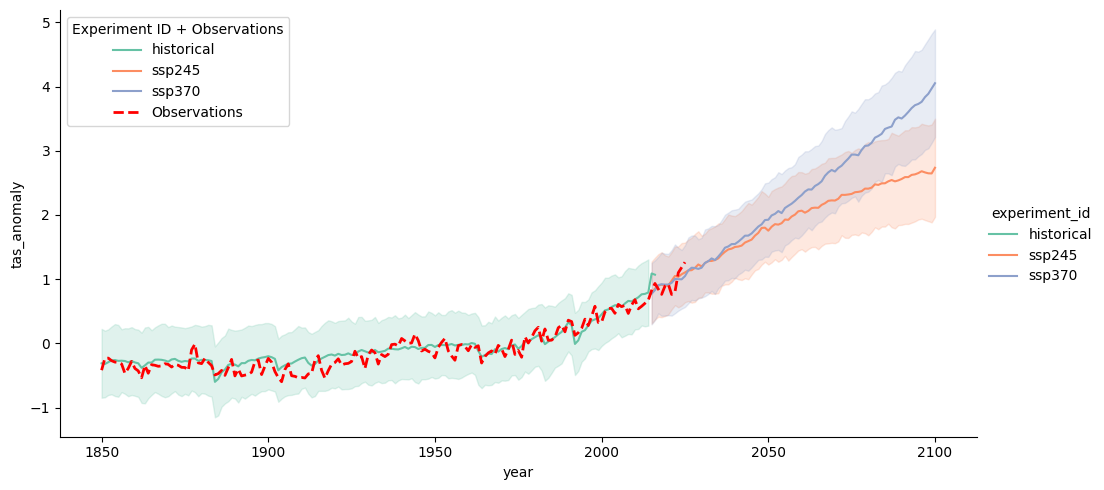

In [24]:
# Create the main plot
g = sns.relplot(data=df_all, x="year", y="tas_anomaly",
                hue='experiment_id', kind="line", errorbar="sd", aspect=2, palette="Set2")  # Adjust the color palette)

# Get the current axis from the FacetGrid
ax = g.ax

# Overlay the observational data in red
sns.lineplot(data=obs_df, x="year", y="tas_anomaly",color="red", 
             linestyle="dashed", linewidth=2,label="Observations", ax=ax)

# Adjust the legend to include observations
ax.legend(title="Experiment ID + Observations")

# Show the plot
plt.show()

In [27]:
# cluster.close()

In [26]:
# sns.relplot(data=df_all,x="year", y="tas_anomaly", hue='experiment_id',kind="line", errorbar="sd", aspect=2)